## DL3 skymap with gammapy
author:
* Tarek Hassan (thassan@ifae.es)
* Cosimo Nigro (cosimonigro2@gmail.com)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Ring2DKernel, Tophat2DKernel
from astropy.visualization import simple_norm

from gammapy.data import DataStore
from gammapy.image import SkyImage, SkyImageList
from gammapy.detect import KernelBackgroundEstimator as KBE

In [2]:
import gammapy

In [3]:
gammapy.__version__

u'0.7'

Prepare first the data on a hdu table file:

In [4]:
from make_veritas_obs_hdu_index import create_obs_hdu_index
create_obs_hdu_index(['./VEGAS/87658_DL3.fits'])


In [5]:
# data_store = DataStore.from_dir('../example_files')
data_store = DataStore.from_dir('./')

In [6]:
source_pos = SkyCoord(83.633083, 22.0145, unit='deg')
# If you have internet access, you could also use this to define the `source_pos`:
# source_pos = SkyCoord.from_name('crab')
print(source_pos)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 83.633083,  22.0145)>


In [7]:
ref_image = SkyImage.empty(
    nxpix=400, nypix=400, binsz=0.02,
    xref=source_pos.ra.deg, yref=source_pos.dec.deg,
    coordsys='CEL', proj='TAN',
)

In [8]:
# Make a counts image for a single observation
events = data_store.obs(obs_id=87658).events
counts_image = SkyImage.empty_like(ref_image)
counts_image.fill_events(events)

(<matplotlib.figure.Figure at 0x108eeb890>,
 <matplotlib.colorbar.Colorbar at 0x109d2e550>)

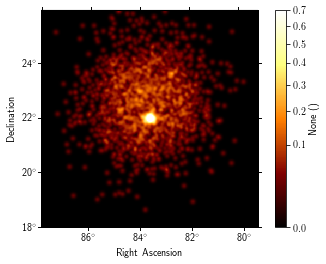

In [9]:
norm = simple_norm(counts_image.data, stretch='sqrt', min_cut=0, max_cut=0.7)
counts_image.smooth(radius=0.1 * u.deg).plot(norm=norm, add_cbar=True)

In [10]:
# we can also take a look at how much is the value of the map in one position, say the nominal position of the Crab
from astropy.coordinates import SkyCoord
counts_image.lookup(source_pos)

8.0

In [11]:
# from astropy.io import fits
# DL3_HDU_ind = fits.open("../example_files/files/VR89029.test.chunk1.fits")
# DL3_HDU_ind[1].header['OBS_ID']

In [13]:
# Making a counts image for multiple observations is a bit inconvenient at the moment
obs_ids = [87658]
counts_image2 = SkyImage.empty_like(ref_image)
for obs_id in obs_ids:
    events = data_store.obs(obs_id=obs_id).events
    counts_image2.fill_events(events)

(<matplotlib.figure.Figure at 0x103da8990>,
 <matplotlib.colorbar.Colorbar at 0x10a2bde10>)

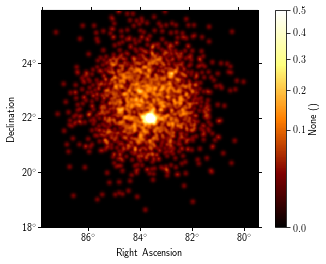

In [14]:
norm = simple_norm(counts_image2.data, stretch='sqrt', min_cut=0, max_cut=0.5)
counts_image2.smooth(radius=0.1 * u.deg).plot(norm=norm, add_cbar=True)

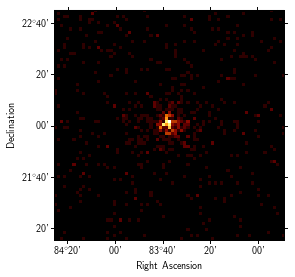

In [15]:
# suppose now we want to take a look at a zoomed part of the countmap 
# 1.5 degree around the source nominal postition
size = u.Quantity([1.5, 1.5], 'deg')
cutout = counts_image2.cutout(source_pos, size)
cutout.show()

## Background modeling
In Gammapy a few different methods to estimate the background are available.

Here we'll use the gammapy.detect.KernelBackgroundEstimator to make a background image and the make a significance image.

Starting from an initial background estimate and exclusion mask (both provided, optionally) the algorithm works as follows:

* Compute significance image
* Create exclusion mask by thresholding significance image
* Compute improved background estimate based on new exclusion mask

The steps are executed repeatedly until the exclusion mask does not change anymore.



In [16]:
source_kernel = Tophat2DKernel(radius=5)
source_kernel.normalize(mode='peak')
source_kernel = source_kernel.array

background_kernel = Ring2DKernel(radius_in=20, width=10)
background_kernel.normalize(mode='peak')
background_kernel = background_kernel.array

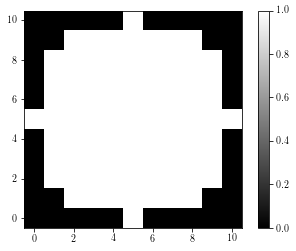

In [17]:
plt.imshow(source_kernel, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.grid('off')

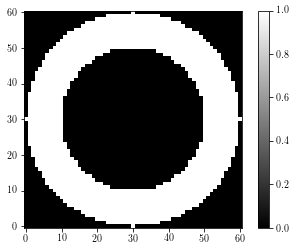

In [18]:
plt.imshow(background_kernel, interpolation='nearest', cmap='gray')
plt.colorbar()
plt.grid('off')

In [19]:
# To use the `KernelBackgroundEstimator` you first have to set
# up a source and background kernel and put the counts image input
# into a container `SkyImageList` class.
images = SkyImageList()
images['counts'] = counts_image2

kbe = KBE(
    kernel_src=source_kernel,
    kernel_bkg=background_kernel,
    significance_threshold=5,
    mask_dilation_radius=0.06 * u.deg,
)
print images
# This takes about 10 seconds on my machine
result = kbe.run(images)

SkyImageList:
Number of images: 1

Image(index=0, name=counts) properties: 
Name: counts
Data shape: (400, 400)
Data type: float64
Data unit: 
Data mean: 1.506e-02
WCS type: ['RA---TAN', 'DEC--TAN']




/usr/local/lib/python2.7/site-packages/gammapy/stats/poisson.py:237: RuntimeWarning: invalid value encountered in greater_equal
  mask = (n_on >= n_on_min)
/usr/local/lib/python2.7/site-packages/gammapy/stats/poisson.py:253: RuntimeWarning: divide by zero encountered in true_divide
  val = np.sqrt(2) * np.sqrt(n_on * np.log(n_on / mu_bkg) - n_on + mu_bkg)
/usr/local/lib/python2.7/site-packages/gammapy/detect/kernel.py:182: RuntimeWarning: invalid value encountered in less
  mask = (significance.data < p['significance_threshold']) | np.isnan(significance)


(<matplotlib.figure.Figure at 0x10a30cc90>,
 <matplotlib.colorbar.Colorbar at 0x10a431210>)

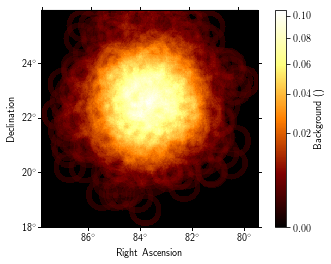

In [20]:
background_image = result['background']
norm = simple_norm(background_image.data, stretch='sqrt')#, min_cut=0, max_cut=0.5)
background_image.plot(norm=norm, add_cbar=True)

(<matplotlib.figure.Figure at 0x10495a910>,
 None)

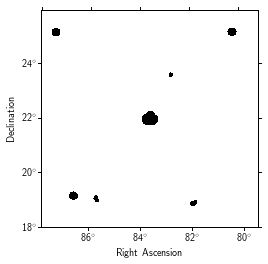

In [21]:
result['exclusion'].plot()

(<matplotlib.figure.Figure at 0x104963950>,
 <matplotlib.colorbar.Colorbar at 0x10b1adcd0>)

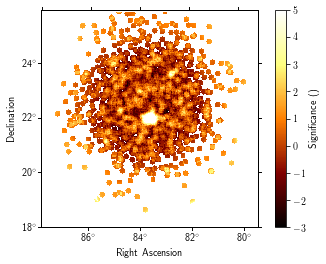

In [22]:
significance_image = result['significance']
significance_image.plot(add_cbar=True, vmin=-3, vmax=5)

In [26]:
np.nanmax(significance_image.data[np.isfinite(significance_image.data)])

29.603786400606197